![UPS](ups.png)
&nbsp;

**Nombre:** Jonathan Atancuri

**Asignatura:** Simulacion

**Carrera:** Ing. Sistemas

**Profesor:** Diego Quisi

# Examen Interciclo-Simulacion

### Objetivo:

* Consolidar los conocimientos adquiridos en clase para desarrollar simulaciones de eventos discretos.

### Introducción:

El golpe económico de la crisis sanitaria del corona virus no va a ser cosa de semanas, sino de meses. Dentro de una de las etapas importantes posteriores a las elecciones presidenciales son el análisis y tendencia que tiene el actual presidente. Para ello se plantea realizar un sistema de regresión que permita identificar cual es la tendencia en base al manejo de las redes sociales (Twitter y/o Facebook) del presidente [1].

Las regresiones lineales pueden aprenden por sí mismos y en este caso obtener automáticamente esa “recta o ecuación” que buscamos con la tendencia de predicción. Para ello se puede medir el error con respecto a los puntos de entrada y el valor “Y” de salida real [3].


#### Enunciado:

*	Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real:
*	Obtener datos de tendencia de twitter o facebook(crawler o webscraping), para ello se puede obtener a través del API [4].
*	Title: Titulo del Post/Twitter
*	Word count: la cantidad de palabras del artículo,
*	number of Links: los enlaces externos que contiene,
*	number of comments: cantidad de comentarios,
*	number Shares: compartidos.
*	HashTag
*	Etc.

En base a ello, se pretende proponer y generar una predicción de cuántas veces será compartido un post/twitter utilizando regresión [2].


# LA API DE TWITER TIENE ALGUNAS LIMITACIONES.

Se puede procesar:

180 requerimientos cada 15 minutos.

TWITER SEARCH: 450 tweets por requerimiento.

USUARIO: 900 usuarios por requerimiento

TIMELINES: 1500 tweets por requerimiento, Solo se puede sacar los últimos 3200 Tweets (incluye los retweets).

In [1]:
#Importamos la librerías necesarias.
import tweepy
import json 
import csv
import codecs
from os import remove
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
from lmfit.models import StepModel, LinearModel

%matplotlib inline

In [2]:
# Ahora procedemos a autenticarnos usando el API Key, el API secret Key, el Access token y el Access token secret que se generaron al crear nuestra aplicación en Twitter.
consumer_key = "7WjRyBLWCmtCutSig0mpqlec5"
consumer_secret = "BCdV2YThbvw6gC7tj5OZbjlR8DSU2gDFwaRjr7Xs1T5P4vmptM"
access_token = "1302969322533519360-tw5klydBCGiTfJ4VhsnJwuOEgK5OYI"
access_token_secret = "E7PuklL3RpWVWOg91PfygcMC9absNBMX5xKm0YXHp2Kgk"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [3]:
#Instancio el objeto.
api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# Datos de la Persona a Buscar

In [7]:

presidente = ['LassoGuillermo']
presidente

['LassoGuillermo']

# FILTRAMOS LOS DATOS.

In [8]:
#remove("presidente.csv")# Descomentar si se va a eliminar para cargar con nuevos datos.
#Seccion de campos a extraer
name, user,follower,text, menciones, likes, hashtags, share = '','', '' ,'','','','',''
#Nombres dentro de csv
rows  = [['Nombre', 'usuario','followers','contenido','menciones','hashtags','likes','veces compartido']]
contador_filas =0
for candidato in presidente:
    #Obtenemos la informacion del presidente.
    data = api.get_user(candidato)
    print('Datos del Presidente: '+ data._json['name'])
    diccionario =data._json['entities'] 
    lista=[]
    
    for link in diccionario :  #recorremos 
        valor = diccionario[link]
        for vrd_valor in valor:
            lista = [lista,valor[vrd_valor]]
        
    new_lista = lista[0]
    listaA=new_lista[1]
    i=0;
    link_presidente=''
    for dia in listaA:
        link = dia
        for links in link:
            i=i+1
            if i == 2:
                link_presidente =link[links]

    print(link_presidente)
    print('Tweets del Presidente.')
    name, user, followers = data._json['name'],data._json['screen_name'],data._json['followers_count']
    print(followers)
    for tweet in tweepy.Cursor(api.user_timeline, screen_name=candidato, tweet_mode = 'extend').items(100):
        diccionario =tweet._json['entities'] 
        hashtags = diccionario['hashtags']
        menciones = diccionario['user_mentions']
        i=0;
        j=0;
        #print('HASHTAGS:')
        users_mnc=''
        hastags=''
        for dia in hashtags:
            hst = dia
            for links in hst:

                i=i+1
                if i == 1:
                    hastags =hst[links]
                    #print(hastags)

        #print('USERS MECIONADOS:')
        for m in menciones:
            mnc = m
           #print(mnc)
            for m_user in mnc:
                j=j+1
                if j == 1:
                    users_mnc=mnc[m_user]
                    #print(mnc[m_user])
        text, menciones, likes,share=tweet._json['text'].encode("utf-8"),users_mnc,tweet._json['favorite_count'],tweet._json['retweet_count']       
        single_row=[name, user, followers, text, menciones,hastags, likes, share]

        rows.append(single_row)
        
with open('presidente.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

Datos del Presidente: Guillermo Lasso
http://www.guillermolasso.ec
Tweets del Presidente.
882232


# RECUPERAMOS LOS DATOS GUARDADOS DE LOS CANDIDATOS

In [9]:
#cargamos los datos de entrada
df= pd.read_csv("presidente.csv", engine='python')

In [10]:
#veamos cuantas dimensiones y registros contiene
df.shape

(100, 8)

In [11]:

#son 100 registros con 8 columnas. Veamos los primeros registros
df.head()

,Nombre,usuario,followers,contenido,menciones,hashtags,likes,veces compartido
0,Guillermo Lasso,LassoGuillermo,882232,"b'En el #D\xc3\xadaNacionalDelVotoFemeninoEc, ...",NaN,DíaNacionalDelVotoFemeninoEc,167,32
1,Guillermo Lasso,LassoGuillermo,882232,b'Convers\xc3\xa9 con el Presidente @lopezobra...,lopezobrador_,NaN,500,59
2,Guillermo Lasso,LassoGuillermo,882232,b'\xc2\xa1El #PlanVacunaci\xc3\xb3n9100 es un ...,NaN,PlanVacunación9100,162,42
3,Guillermo Lasso,LassoGuillermo,882232,b'Agradecido y comprometido con el Ecuador del...,NaN,NaN,882,128
4,Guillermo Lasso,LassoGuillermo,882232,"b'Si ya fuiste vacunado, puedes registrar la i...",NaN,NaN,360,132


In [12]:
# Ahora veamos algunas estadísticas de nuestros datos
df.describe()

,followers,likes,veces compartido
count,100.0,100.000000,100.000000
mean,882232.0,437.760000,81.320000
std,0.0,913.257342,134.235951
min,882232.0,0.000000,0.000000
25%,882232.0,2.000000,0.000000
50%,882232.0,9.500000,3.500000
75%,882232.0,495.500000,114.750000
max,882232.0,6585.000000,879.000000


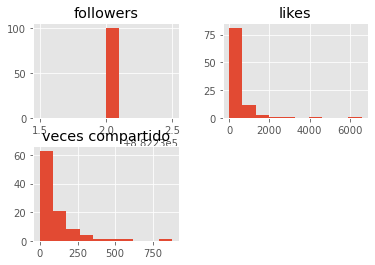

In [13]:
# Visualizamos rápidamente las caraterísticas de entrada
df.drop(['contenido'],1).hist()
plt.show()

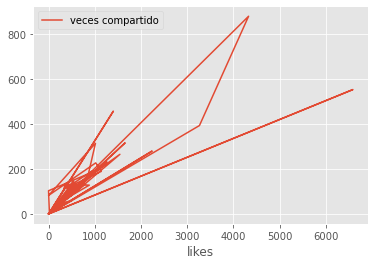

In [14]:
df.plot(x ='likes' , y='veces compartido')

# UNA VEZ OBTENIDOS LO DATOS SE PROCECE A HACER LA REGRESION PARA ELLO TOMANDO  LA CANTIDAD DE LIKES .

# GUILLERMO LASSO

In [15]:
dfA = df[df['Nombre'].isin(['Guillermo Lasso'])] #Filtro la Informacion para Guillermo Lasso
dfA

,Nombre,usuario,followers,contenido,menciones,hashtags,likes,veces compartido
0,Guillermo Lasso,LassoGuillermo,882232,"b'En el #D\xc3\xadaNacionalDelVotoFemeninoEc, ...",NaN,DíaNacionalDelVotoFemeninoEc,167,32
1,Guillermo Lasso,LassoGuillermo,882232,b'Convers\xc3\xa9 con el Presidente @lopezobra...,lopezobrador_,NaN,500,59
2,Guillermo Lasso,LassoGuillermo,882232,b'\xc2\xa1El #PlanVacunaci\xc3\xb3n9100 es un ...,NaN,PlanVacunación9100,162,42
3,Guillermo Lasso,LassoGuillermo,882232,b'Agradecido y comprometido con el Ecuador del...,NaN,NaN,882,128
4,Guillermo Lasso,LassoGuillermo,882232,"b'Si ya fuiste vacunado, puedes registrar la i...",NaN,NaN,360,132
...,...,...,...,...,...,...,...,...
95,Guillermo Lasso,LassoGuillermo,882232,b'RT @ComunicacionEc: El Ministerio del Ambien...,ComunicacionEc,NaN,0,82
96,Guillermo Lasso,LassoGuillermo,882232,"b'Desde Bucay, junto a la comunidad Shuar de r...",Ambiente_Ec,NaN,1021,227
97,Guillermo Lasso,LassoGuillermo,882232,b'El Ecuador del encuentro se trata de sumar n...,NaN,NaN,1140,189
98,Guillermo Lasso,LassoGuillermo,882232,b'Celebramos el #D\xc3\xadaMundialDelMedioAmbi...,NaN,DíaMundialDelMedioAmbiente,362,113


In [16]:
dfA= dfA.loc[:,['likes']] #Selecciono las columnas de analisis
dfA

,likes
0,167
1,500
2,162
3,882
4,360
...,...
95,0
96,1021
97,1140
98,362


In [17]:
#Creamos una funcion para cargar el numero de dias.
dias=[]
def numeroDias(tamano=100):
    for i in range(tamano):
        dias.append(i)
        #print(i)
    return dias
dias = numeroDias()
np.array(dias)
# = numeroDias()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [18]:
x = np.array(dias)#Cada uno de los días.
#print(x)
y = dfA.loc[:,['likes']]
#print(y)
# Creo un modelo de regresión lineal
modelo = linear_model.LinearRegression()
 
# Entreno el modelo con los datos (X,Y)
modelo.fit(np.array(x).reshape(-1,1), y)

#Ahora vamoa a calcular b_0
print (u'Ordenada al origen: ', modelo.intercept_)

# Ahora puedo obtener el coeficiente b_1
print (u'Pendiente: ', modelo.coef_[0])
beta = modelo.coef_[0]#Modificar el valor de la pendiente.
# Podemos predecir usando el modelo
y_pred = modelo.predict(np.array(x).reshape(-1,1))
 
# Por último, calculamos el error cuadrático medio y el estadístico R^2(Precisión del modelo.)
print (u'Error cuadrático medio: %.2f' % mean_squared_error(y, y_pred))
print (u'Estadístico R_2: %.2f' % r2_score(y, y_pred))

Ordenada al origen:  [10.54158416]
Pendiente:  [8.63067507]
Error cuadrático medio: 763631.00
Estadístico R_2: 0.08


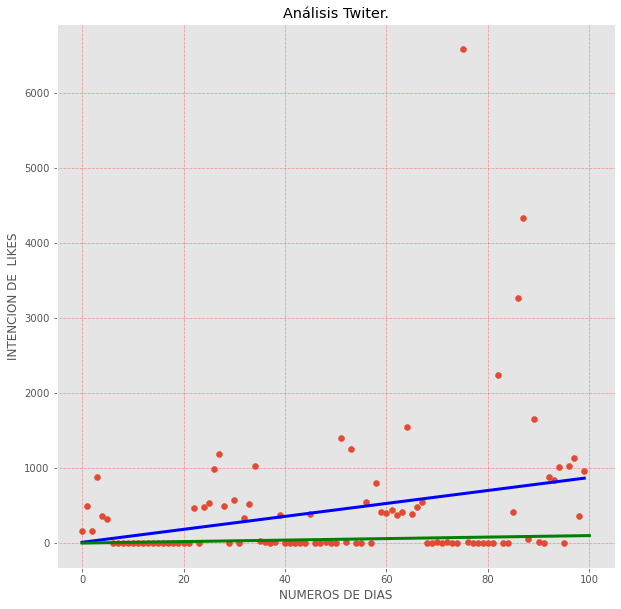

In [19]:
#Graficar
#Tamaño
plt.rcParams['figure.figsize'] = [10, 10]
# Representamos el ajuste (rojo) y la recta Y = beta*x (verde)
plt.scatter(x, y)#Dibujo mis puntos originales
plt.plot(x, y_pred, color='blue',linewidth=3.0) #Dibujo con los valores ya predecidos.

#Dibujamos puntos reales.
x_real = np.array([0, 100])
y_real = x_real
plt.plot(x_real, y_real, color='green',linewidth=3.0)


#Propiedades
plt.title('Análisis Twiter.')
plt.xlabel('NUMEROS DE DIAS')
plt.ylabel('INTENCION DE  LIKES')
plt.grid(color='r', linestyle='dotted', linewidth=0.5)
plt.show()

In [20]:
#Vamos ver el impacto de proximo tuit, haciendo referencia  a personas que le siguen  debido a que se interesan en sus publicaciones.
impacto = y_pred[100-1]
print('Intención de LIKES',impacto )

Intención de LIKES [864.97841584]


# Regresión Lineal Múltiple en Python


Vamos a extender el ejercicio utilizando más de una variable de entrada para el modelo. Esto le da mayor poder al algoritmo de Machine Learning, pues de esta manera podremos obtener predicciones más complejas.

Nuestra “ecuación de la Recta”, ahora pasa a ser:

**Y = b + m1 X1 + m2 X2 + … + m(n) X(n)**

En nuestro caso, utilizaremos 2 “variables predictivas” para poder graficar en 3D, pero recordar que para mejores predicciones podemos utilizar más de 2 entradas y prescindir del grafico.

Nuestra primer variable sera veces compartido y la segunda variable será la suma de 2 columnas de entrada: followers, likes



In [36]:
#Vamos a intentar mejorar el Modelo, con una dimensión más: 
# Para poder graficar en 3D, haremos una variable nueva que será la suma de los likes , veces compartido
suma = (df["likes"] + df['veces compartido'].fillna(0))
 
dataX2 =  pd.DataFrame()
dataX2["followers"] = df["followers"]
dataX2["suma"] = suma
XY_train = np.array(dataX2)
z_train = df['veces compartido'].values

Ya tenemos nuestras 2 variables de entrada en XY_train y nuestra variable de salida pasa de ser “Y” a ser el eje “Z”.

Creamos un nuevo objeto de Regresión lineal con SKLearn pero esta vez tendrá las dos dimensiones que entrenar: las que contiene XY_train. Al igual que antes, imprimimos los coeficientes y puntajes obtenidos:



In [37]:
# Creamos un nuevo objeto de Regresión Lineal
regr2 = linear_model.LinearRegression()
 
# Entrenamos el modelo, esta vez, con 2 dimensiones
# obtendremos 2 coeficientes, para graficar un plano
regr2.fit(XY_train, z_train)
 
# Hacemos la predicción con la que tendremos puntos sobre el plano hallado
z_pred = regr2.predict(XY_train)
 
# Los coeficientes
print('Coefficients: \n', regr2.coef_)
# Error cuadrático medio
print("Mean squared error: %.2f" % mean_squared_error(z_train, z_pred))
# Evaluamos el puntaje de varianza (siendo 1.0 el mejor posible)
print('Variance score: %.2f' % r2_score(z_train, z_pred))

Coefficients: 
 [0.         0.11883933]
Mean squared error: 2872.67
Variance score: 0.84


Text(0.5, 0.92, 'Regresión Lineal con Múltiples Variables')

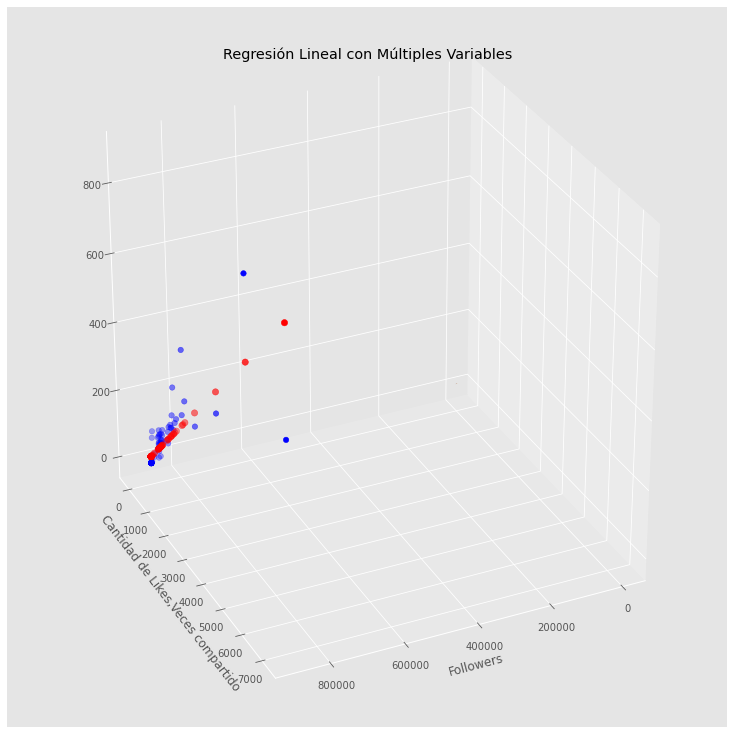

In [39]:
fig = plt.figure()
ax = Axes3D(fig)
 
# Creamos una malla, sobre la cual graficaremos el plano
xx, yy = np.meshgrid(np.linspace(0, 3500, num=10), np.linspace(0, 60, num=10))
 
# calculamos los valores del plano para los puntos x e y
nuevoX = (regr2.coef_[0] * xx)
nuevoY = (regr2.coef_[1] * yy) 
 
# calculamos los correspondientes valores para z. Debemos sumar el punto de intercepción
z = (nuevoX + nuevoY + regr2.intercept_)
 
# Graficamos el plano
ax.plot_surface(xx, yy, z, alpha=0.2, cmap='hot')
 
# Graficamos en azul los puntos en 3D
ax.scatter(XY_train[:, 0], XY_train[:, 1], z_train, c='blue',s=30)
 
# Graficamos en rojo, los puntos que 
ax.scatter(XY_train[:, 0], XY_train[:, 1], z_pred, c='red',s=40)
 
# con esto situamos la "camara" con la que visualizamos
ax.view_init(elev=30., azim=65)
        
ax.set_xlabel('Followers')
ax.set_ylabel('Cantidad de Likes,Veces compartido')
ax.set_title('Regresión Lineal con Múltiples Variables')

# Predicción con el modelo de Mútiples Variables

In [40]:
# Si quiero predecir cuántos "Compartidos" voy a obtener por un artículo con: 
#  seguidores: 882120, likes: 194, 
# según nuestro modelo, hacemos:
 
z_Dosmil = regr2.predict([[882150, 194+4+6]])
print(int(z_Dosmil))

43


# Aplicacion de la Simulacion

* Posteriormente se debe seguir un procesos de vacunación en los recintos electorales que se describe a continuación (Tomar el proceso para el proyecto final):
  * Solo se va a tener en cuanta uno de los recintos electorales (investigar datos de cuantas personas asisten a votar).
  * Tomar los resultados de la regresión para la vacuna según la llegada.
  * Se tiene una promedio que el 80% de personas realizaran el proceso de vacunación dentro del Ecuador.
  * Dentro del procesos se tiene que alrededor del 5% - 10% no podrán vacunarse.
  * Las personas solo tiene un recinto electoral para realizar el proceso.
  * Las personas realizan la primera vacuna y 30 días después la segunda vacuna.
  * La persona se acerca a la mesa  y hacen fila en caso de ser necesario para recibir la vacuna.
  * Realiza la vacunación en un tiempo aleatorio entre 5 a 10 minutos.
  * Debe esperar 20 minutos dentro del establecimiento para verificar que no tenga problemas de salud.
  * La persona recibe su certificado de vacunación y la fecha de la próxima vacuna entre 2 – 3 minutos.
  * La persona sale del recinto electoral.
  * Regresan para la próxima fecha y se repite el ciclo.
* El proceso de simulación desarrollado deberá considerar los siguientes aspectos:
  * Se debe establecer un modelo basado en modelos matemáticos para la predicción del numero de veces que se compartirá o la tendencia del presidente basada en redes sociales.
  * El programa deberá generar gráficas que indiquen la ecuación matemática de las tendencias .
  * Deben calcularse las siguientes métricas del sistema de simulación de eventos discretos :
    * Total de de personas que realizaron el proceso de vacunación.
    * Grafico del porcentaje de personas que no recibieron la vacuna.
    * El tiempo promedio de espera.


In [41]:
# Importamos las librerias
import random
import simpy

In [42]:
RANDOM_SEED = 42
NUMERO_PERSONAS = 4  # Numero promedio de personas a vacunarse que llegan al mismo tiempo
NUMERO_MESAS = 2     # Numero de mesas receptoras  disponibles en el recinto para la vacunacion
TIEMPO_VACUNACION = 5  # Tiempo promedio que las personas se demoran en vacunarse
TIEMPO_LEGADA = 10    # Tiempo promedio de la llegada de las personas
SIM_TIME = 100     # Simulation time in minutes

In [43]:
TIEMPOS = []

In [44]:
class Recinto(object):
    """
        Clase recinto, encargado del proceso de votacion
    """
    def __init__(self, env, numero_mesas, tiempo_vacunacion):
        self.env = env
        self.tiempo_vacunacion = tiempo_vacunacion
        self.mesas_electorales = simpy.Resource(env, numero_mesas)

    def vacunacion(self, persona):
        """
            Realiza el proceso de vacunacion.
        """
        yield self.env.timeout(self.tiempo_vacunacion)
        self.seleccion_persona()
        # Espera la entrega del certificado
        timepo_cetificado = random.expovariate(1.0 / self.tiempo_vacunacion)
        yield env.timeout(timepo_cetificado)
        print(f'{persona} recibe su certificado votación a las {env.now}')
    
    def seleccion_persona(self):
        """
            Realiza el proceso de la selecion de la persona
        """
        pass
        
        
def persona(env, name, recinto):
    """
        Metodo donde el la persona que recibe la vacuna  hace uso de una mesa electoral y
        procede con la vacunacion
    """
    print(f'{name} llega a la mesa electoral y hace fila a las  {env.now}')
    with recinto.mesas_electorales.request() as mesa:
        yield mesa

        print(f'{name} entra al proceso de vacunacion a las {env.now}.')
        yield env.process(recinto.vacunacion(name))
        print(f'{name} sale del recinto electoral a las {env.now}.')

def agregar_personas(tiempo, personas):
    cantidad = 0
    if len(TIEMPOS):
        cantidad = TIEMPOS[-1].get('cantidad')
    # Agrega los nuevas personas
    TIEMPOS.append({'tiempo': tiempo, 'cantidad': cantidad + personas})
    
def setup(env, num_mesas, time_votacion, time_llegada):
    """
        Creacion del recinto electoral, y el generado aleatorio 
        de personas que van a vacunarse
    """
    # Crea el recinto electoral
    recinto = Recinto(env, num_mesas, time_votacion)
    # Create el ingreso de votantes a las mesas
    numero = 0
    while True:
        numero += 1
        personas = random.randint(1, NUMERO_PERSONAS)
        # Crea un numero randomico de votantes
        for i in range(personas):
            env.process(persona(env, f'PER[{numero}.{i+1}]', recinto))
        # Agrega el numero de personas a vacunarse
        agregar_personas(env.now, personas)
        # Espera el tiempo de llegada
        yield env.timeout(random.randint(time_llegada - 5, time_llegada + 5))

In [45]:
print('VACUNAS AZUAY - RECINTO #1')
random.seed(RANDOM_SEED)
env = simpy.Environment()
env.process(setup(env, NUMERO_MESAS, TIEMPO_VACUNACION, TIEMPO_LEGADA))
# Execute!
env.run(until=SIM_TIME)

VACUNAS AZUAY - RECINTO #1
PER[1.1] llega a la mesa electoral y hace fila a las  0
PER[1.1] entra al proceso de vacunacion a las 0.
PER[2.1] llega a la mesa electoral y hace fila a las  5
PER[2.2] llega a la mesa electoral y hace fila a las  5
PER[2.3] llega a la mesa electoral y hace fila a las  5
PER[2.1] entra al proceso de vacunacion a las 5.
PER[1.1] recibe su certificado votación a las 6.262930928350568
PER[1.1] sale del recinto electoral a las 6.262930928350568.
PER[2.2] entra al proceso de vacunacion a las 6.262930928350568.
PER[3.1] llega a la mesa electoral y hace fila a las  13
PER[2.1] recibe su certificado votación a las 16.667963364040414
PER[2.1] sale del recinto electoral a las 16.667963364040414.
PER[2.3] entra al proceso de vacunacion a las 16.667963364040414.
PER[2.2] recibe su certificado votación a las 16.90879597234353
PER[2.2] sale del recinto electoral a las 16.90879597234353.
PER[3.1] entra al proceso de vacunacion a las 16.90879597234353.
PER[3.1] recibe su ce

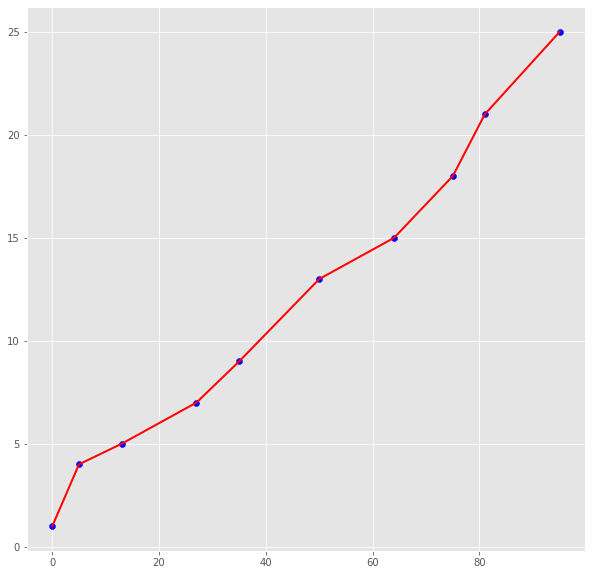

In [47]:
tiempos = pd.DataFrame(TIEMPOS)
plt.plot(tiempos['tiempo'], tiempos['cantidad'], linewidth=2,color='red')
plt.scatter(tiempos['tiempo'], tiempos['cantidad'], color='blue')
plt.grid(True)
plt.show()

In [48]:
# IMPRESION DE RESULTADOS
print("TOTAL VACUNADOS:",  TIEMPOS[-1]['cantidad'])
print("TIEMPO PROMEDIO ESPERA:",  tiempos['tiempo'].mean())

TOTAL VACUNADOS: 25
TIEMPO PROMEDIO ESPERA: 44.5


# Conclusiones
El desarollo del presente trabajo me permitió poder expandir mis conocimientos sobre el funcionamiento de las regresiones y la utilidad de la mismas para poder predecir datos en el futuro, de las misma manera sobre la utilidad de la simulacion de eventos discretos para poder simular situaciones de la vida real.

